In [1]:
%set_env PYTORCH_ENABLE_MPS_FALLBACK=1
%set_env YOLO_MODE=S

env: PYTORCH_ENABLE_MPS_FALLBACK=1
env: YOLO_MODE=S


In [2]:
from transformers import YolosImageProcessor, YolosForObjectDetection
from PIL import Image
from matplotlib import pyplot as plt
import torch
import requests
import numpy as np
import cv2, os

DEVICE_STRING = "cpu"

os.environ['YOLO_MODE'] = 'CLIENT'
client_model = YolosForObjectDetection.from_pretrained("hustvl/yolos-tiny").to(device=DEVICE_STRING)

os.environ['YOLO_MODE'] = 'NONE'
image_processor = YolosImageProcessor.from_pretrained("hustvl/yolos-tiny")


os.environ['YOLO_MODE'] = 'SERVER'
server_model = YolosForObjectDetection.from_pretrained("hustvl/yolos-tiny").to(device=DEVICE_STRING)

/Users/icevin/opt/anaconda3/envs/conv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


True False


The `max_size` parameter is deprecated and will be removed in v4.26. Please specify in `size['longest_edge'] instead`.


False True


In [48]:
url = "http://images.cocodataset.org/val2017/000000039769.jpg"
image = Image.open(requests.get(url, stream=True).raw)

inputs = image_processor(images=image, return_tensors="pt").to(device=DEVICE_STRING)

pixel_values = inputs['pixel_values'] 
p_height=pixel_values.shape[-2]
p_width=pixel_values.shape[-1]

outputs = client_model(**inputs)

print(p_height, p_width)

pixels.size: 80
get_head_mask: 3.245903644710779e-05
embeddings.size: 80
embeddings: 0.09945666597923264
512 682


In [47]:
client_outputs = new.clone().detach()
server_inputs = client_outputs.type(torch.float32)
server_outputs = server_model(None, input_embeddings=server_inputs, p_height=p_height, p_width=p_width)

server loaded input embeddings
encoder: 1.3352295000222512
encoder_outputs.size: 80
layernorm: 0.0005005410057492554
pooler: 1.8584018107503653e-05
vit: 1.3363790409639478
16
344
80
class_labels_classifier: 0.008983083011116832
bbox: 0.004172208020463586


In [28]:
outputs.dtype
torch.save(outputs, "old.pt")

In [26]:
new = outputs.type(torch.float16)
torch.save(new, "new.pt")

In [22]:
sys.getsizeof(new)

80

In [14]:
import sys
print(sys.getsizeof(outputs), sys.getsizeof(pixel_values))


80 80


tensor([[[ 0.0507, -0.1440, -1.4637,  ..., -1.6377,  1.3644,  1.2034],
         [ 1.2663,  0.0654, -2.4165,  ..., -1.1598,  0.1424, -0.3612],
         [ 1.4113,  0.2051, -2.7063,  ..., -1.1898,  0.0401, -0.2490],
         ...,
         [ 0.0780,  0.0720, -0.0103,  ...,  0.1135,  0.0864, -0.0178],
         [-0.0307, -0.0489,  0.0411,  ..., -0.1344,  0.0314,  0.1786],
         [-0.0288,  0.0484, -0.0331,  ...,  0.0668, -0.0344, -0.0901]]],
       grad_fn=<AddBackward0>)

In [50]:
client_outputs = new.clone().detach()
server_inputs = client_outputs.type(torch.float32)
server_inputs = server_inputs.to("cpu", dtype=torch.float32)
server_outputs = server_model(None, input_embeddings=server_inputs, p_height=p_height, p_width=p_width)

server loaded input embeddings
encoder: 1.7263371670269407
encoder_outputs.size: 80
layernorm: 0.0013448750250972807
pooler: 0.0002487919991835952
vit: 1.7289978750050068
16
344
80
class_labels_classifier: 0.014532291970681399
bbox: 0.009242042026016861


In [ ]:
pixels.size: 80
get_head_mask: 5.458015948534012e-06
embeddings.size: 80
embeddings: 0.016195750038605183
encoder: 1.1489454580005258
encoder_outputs.size: 344
layernorm: 0.0008922909619286656
pooler: 4.5803608372807503e-07
vit: 1.1665820840280503
80
344
80
class_labels_classifier: 0.0011414170148782432
bbox: 0.0006464580073952675

In [6]:
def pil_to_cv2(pil_image):
    open_cv_image = np.array(pil_image)
    return open_cv_image[:, :, ::-1].copy()

In [8]:
target_sizes = torch.tensor([image.size[::-1]]).to(device=DEVICE_STRING)
results = image_processor.post_process_object_detection(
    outputs, threshold=0.8, target_sizes=target_sizes
)[0]

a_img = pil_to_cv2(image)
# a_img = image.copy()
for score, label, box in zip(results["scores"], results["labels"], results["boxes"]):
    start_point = (int(box[0]), int(box[1]))
    end_point = (int(box[2]), int(box[3]))
    cv2.rectangle(a_img, start_point, end_point, (0, 0, 255), thickness=1, lineType=cv2.LINE_8)
    cv2.putText(a_img,
                f"{client_model.config.id2label[label.item()]} with {round(score.item(), 3)}",
                # f"cutie with 100%",
                start_point,
                fontFace=cv2.FONT_HERSHEY_TRIPLEX,
                fontScale=1,
                color=(0, 255, 0),
                thickness=2,
                )
    # print(box)
    # box = [round(i, 2) for i in box.tolist()]
    # print(
    #     f"Detected {self.model.config.id2label[label.item()]} with confidence "
    #     f"{round(score.item(), 3)} at location {box}"
    # )

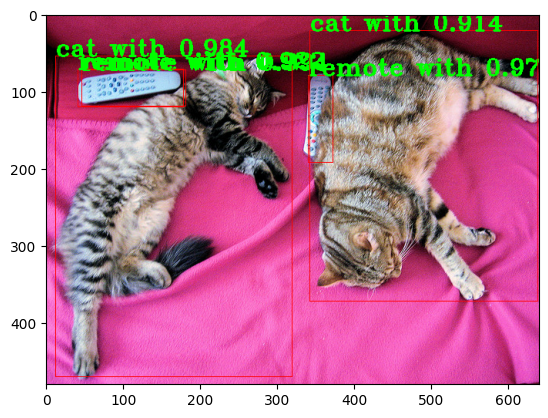

In [ ]:
img2 = a_img[:,:,::-1]
plt.imshow(img2)